In [1]:
import sys
import os
sys.path.append('../src')


In [2]:
import numpy as np
import pandas as pd
import pcalg
import networkx as nx
from conditional_independence import partial_correlation_suffstat, partial_correlation_test
from mcmc.mcmc import PartitionMCMC, StructureMCMC
from mcmc.data import SyntheticDataset
from mcmc.proposals import PartitionProposal
from mcmc.scores import BGeScore, BDeuScore

In [3]:
np.random.seed(32205)
data = np.zeros((200, 3))

data[:,0] = np.random.choice([1,2], size=200)
data[:,1] = np.random.choice([3,4], size=200)
data[:,2] = np.logical_and(data[:,0]==1, data[:,1]==3)
data = pd.DataFrame(data, columns=['A', 'B', 'C'])
gt = np.array([[0,0,1],[0,0,1],[0,0,0]])

In [4]:
data

,A,B,C
0,1.0,3.0,1.0
1,1.0,3.0,1.0
2,1.0,3.0,1.0
3,2.0,4.0,0.0
4,2.0,3.0,0.0
...,...,...,...
195,1.0,4.0,0.0
196,2.0,4.0,0.0
197,1.0,4.0,0.0
198,2.0,4.0,0.0


In [5]:
# M = StructureMCMC(max_iter=5000, data=data, score_object='bge', pc_init=False)
M = PartitionMCMC(max_iter=3000, data=data, score_object='bde', pc_init=False)

In [6]:
mcmc_results, acceptance = M.run()
graphs = M.get_mcmc_res_graphs(mcmc_results)
print('Acceptance_ratio:', acceptance)

Acceptance_ratio: 0.449


In [7]:
from mcmc.utils.graph_utils import generate_key_from_adj_matrix

BURN_IN = 0.1

graphs = M.get_mcmc_res_graphs(mcmc_results)

key = generate_key_from_adj_matrix(gt)
keys, counts = np.unique([generate_key_from_adj_matrix(g) for g in graphs[int(BURN_IN*len(graphs)):]], return_counts=True)
print(key in keys)

True


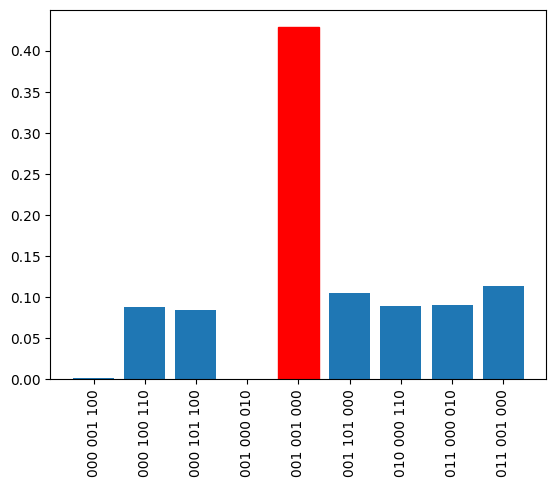

In [8]:
from matplotlib import pyplot as plt

bars = plt.bar(range(len(keys)), counts/sum(counts))
plt.xticks(range(len(keys)), keys, rotation=90);
bars[np.where(keys==key)[0][0]].set_color('red')

-382.49056339198836


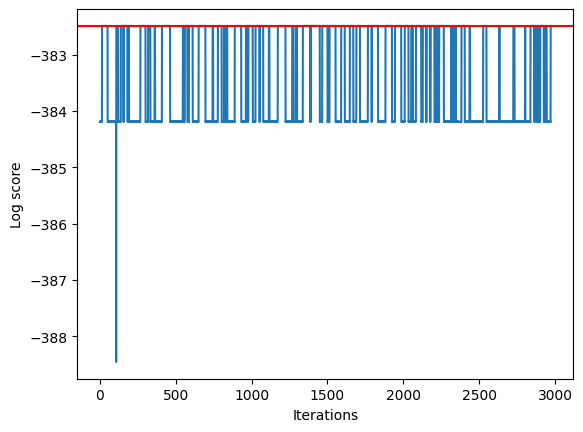

In [9]:
from mcmc.utils.partition_utils import convert_partition_to_party_permy_posy
from mcmc.utils.score_utils import partition_score
from mcmc.utils.partition_utils import convert_partition_to_party_permy_posy, build_partition

def get_mcmc_scores(results):
        mcmc_graph_lst = []
        for i in results:
            mcmc_graph_lst.append( results[i]['score_P_curr'] )
        return mcmc_graph_lst
scores = get_mcmc_scores(mcmc_results)

true_partition = build_partition(incidence=gt, node_labels=list(data.columns))
party_curr, permy_curr, posy_curr = convert_partition_to_party_permy_posy(true_partition)
true_score = partition_score(M.node_labels, M.node_labels, M.parent_table, M.score_table, permy_curr, party_curr, posy_curr )
true_score = sum(true_score['total_scores'].values())
plt.plot(range(len(scores)), scores)
plt.axhline(true_score, color='r')
plt.xlabel('Iterations')
plt.ylabel('Log score')
print(true_score)

In [10]:
from mcmc.evaluation.metrics import kl_divergence, jensen_shannon_divergence, mean_squared_error, mean_absolute_error
from mcmc.inference.posterior import generate_all_dags_keys, generate_all_dags

all_dags = generate_all_dags(data=data, my_score=BDeuScore)

Total 3 node DAGs generated = 25


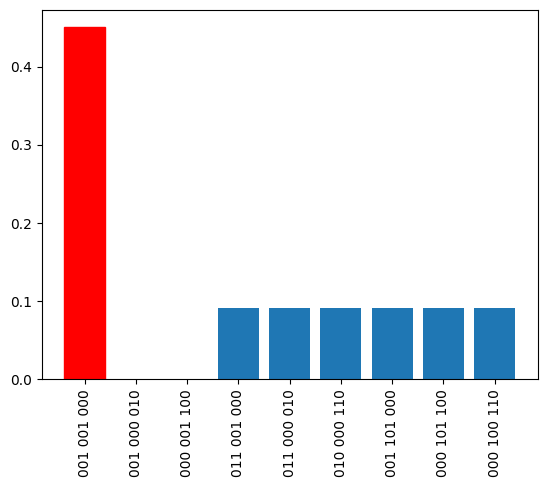

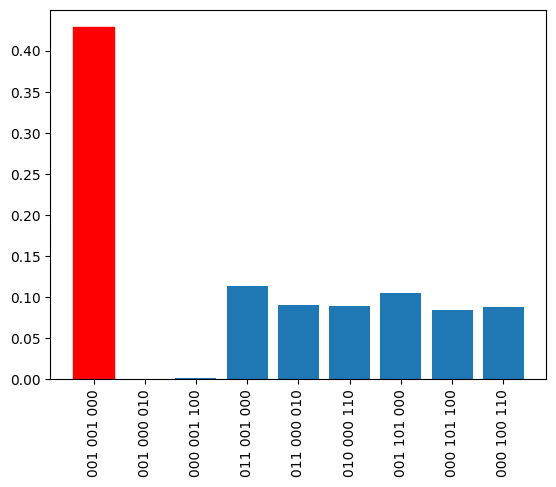

In [11]:

from mcmc.inference.posterior import compute_true_distribution

true_distribution = compute_true_distribution(all_dags)
dst = {key:count/sum(counts) for key, count in zip(keys, counts)}
approx_distribution = {key: (dst[key] if key in dst else 0) for key in true_distribution.keys()}

threshold = 1e-5
k = list(true_distribution.keys())
for _k in k:
    if true_distribution[_k] < threshold and approx_distribution[_k] < threshold:
        del true_distribution[_k]
        del approx_distribution[_k]
k = np.array(list(true_distribution.keys()))
bars = plt.bar(k, true_distribution.values())
# print(k, key)
bars[np.where(k==key)[0][0]].set_color('red')
plt.xticks(range(len(true_distribution.keys())), true_distribution.keys(), rotation=90);
plt.figure()
bars = plt.bar(approx_distribution.keys(), approx_distribution.values())
bars[np.where(k==key)[0][0]].set_color('red')
plt.xticks(range(len(approx_distribution.keys())), approx_distribution.keys(), rotation=90);

In [12]:
from mcmc.evaluation.metrics import mean_squared_error, mean_absolute_error, kl_divergence, jensen_shannon_divergence

print('KL div', kl_divergence(approx_distribution, true_distribution))
print('JS div', jensen_shannon_divergence(approx_distribution, true_distribution))
print('MSE', mean_squared_error(true_distribution, approx_distribution))
print('MAE', mean_absolute_error(true_distribution, approx_distribution))

KL div 0.039641709494066264
JS div 0.001694020696962073
MSE 0.00013301421195727528
MAE 0.008240644021273688
